In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sys.path.append('/users/mtaranov/genome3D/')
from models_3d import Genome3D_RandomForest
from metrics import ClassificationResult
from utils import get_features, get_labels, subsample_data, normalize_features, reconstruct_2d, printMatrix, binarize, zscore, get_2D, plot_prediction, change_scale 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
contacts='pe'
path='/users/mtaranov/datasets_3d/by_chr_dist_matched_'+contacts+'/'
X_train = get_features(path+'d0_X_train_thres_10.npy')
y_train = get_labels(path+'d0_y_train_thres_10.npy')
X_valid = get_features(path+'d0_X_valid_thres_10.npy')
y_valid = get_labels(path+'d0_y_valid_thres_10.npy')
X_test = get_features(path+'d0_X_test_thres_10.npy')
y_test = get_labels(path+'d0_y_test_thres_10.npy')

In [21]:
X_train_normalized, X_valid_normalized, X_test_normalized = normalize_features(X_train, X_valid, X_test)

In [22]:
X_train_pairs = X_train_normalized.reshape(X_train_normalized.shape[0],X_train_normalized.shape[2]*X_train_normalized.shape[3])
X_valid_pairs = X_valid_normalized.reshape(X_valid_normalized.shape[0],X_valid_normalized.shape[2]*X_valid_normalized.shape[3])
X_test_pairs = X_test_normalized.reshape(X_test_normalized.shape[0],X_test_normalized.shape[2]*X_test_normalized.shape[3])

In [23]:
X_train_pairs.shape

(6710, 20)

# RF

### w/o genomic locations

# Estimating hyper-parameter using held out validation set

In [37]:
X_train_valid_pairs = np.concatenate((X_train_pairs, X_valid_pairs), axis=0)
y_train_valid = np.concatenate((y_train, y_valid), axis=0)

In [38]:
# test_fold to 0 for all samples that are part of the validation set, and to -1 for all other samples.
valid_index=[-1 for i in range(X_train_pairs.shape[0])]+[0 for i in range(X_valid_pairs.shape[0])]

In [49]:
param_grid = {'n_estimators': [100, 200, 500], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'log2' ], 'max_depth': [None, 2, 3, 5], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3], 'min_impurity_split': [0.0 , 0.1, 0.2]}

In [51]:
best_param={}

In [52]:
rf = Genome3D_RandomForest(best_param)

In [53]:
best_param = rf.train_cross_val(X_train_valid_pairs[:,:18], [i for i in y_train_valid[:,0]], valid_index, param_grid)

In [54]:
best_param

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_impurity_split': 0.1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

# Random Forest Predictions

In [25]:
rf = Genome3D_RandomForest(best_param)

In [27]:
rf.train(X_train_pairs[:,:18], y_train)
preds_test = rf.predict(X_test_pairs[:,:18])
preds_train = rf.predict(X_train_pairs[:,:18])
print ('On Test:\n{}\n'.format(ClassificationResult(y_test, preds_test)))
print ('On Train:\n{}\n'.format(ClassificationResult(y_train, preds_train)))

On Test:
Balanced Accuracy: 65.38%	 auROC: 0.787	 auPRC: 0.747	 auPRG: 0.600
Positve Accuracy: 92.11%	 Negative Accuracy: 38.66%
Recall at 5%|10%|20% FDR: 0.0%|0.0%|51.0%	 Num Positives: 494	 Num Negatives: 494	 

On Train:
Balanced Accuracy: 99.67%	 auROC: 1.000	 auPRC: 1.000	 auPRG: 1.000
Positve Accuracy: 99.52%	 Negative Accuracy: 99.82%
Recall at 5%|10%|20% FDR: 99.8%|99.8%|100.0%	 Num Positives: 3355	 Num Negatives: 3355	 



# Random Forest Feature Selection

In [28]:
scores=rf.ImportanceSelect()
scores=scores.reshape(scores.shape[0],1)

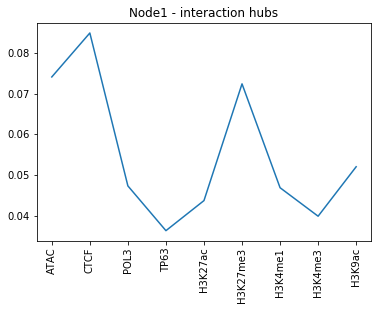

In [29]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
plt.plot(scores[0:18:2])
x = [float(j) for j in range(np.shape(scores)[0]/2)]
plt.xticks(x, features, rotation='vertical')
plt.title('Node1 - interaction hubs')

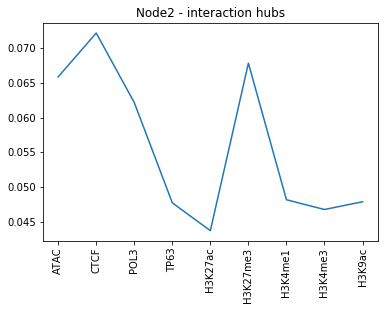

In [30]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
plt.plot(scores[1:21:2])
x = [float(j) for j in range(np.shape(scores)[0]/2)]
plt.xticks(x, features, rotation='vertical')
plt.title('Node2 - interaction hubs')

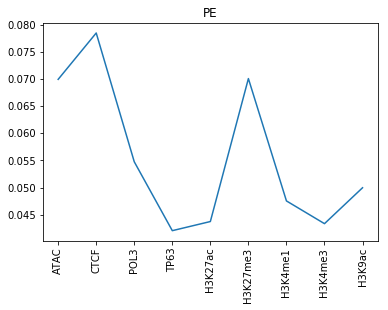

In [31]:
features = ['ATAC', 'CTCF', 'POL3', 'TP63', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K9ac']
plt.plot(np.mean(np.concatenate((scores[0:20:2], scores[1:21:2]), axis=1), axis=1))
x = [float(j) for j in range(np.shape(scores)[0]/2)]
plt.xticks(x, features, rotation='vertical')    
plt.title('PE')

# Random Forest with default hyper-parameters

In [71]:
rf = Genome3D_RandomForest({})
rf.train(X_train_pairs[:,:18], y_train)
preds_test = rf.predict(X_test_pairs[:,:18])
preds_train = rf.predict(X_train_pairs[:,:18])
print ('On Test:\n{}\n'.format(ClassificationResult(y_test, preds_test)))
print ('On Train:\n{}\n'.format(ClassificationResult(y_train, preds_train)))

On Test:
Balanced Accuracy: 63.97%	 auROC: 0.754	 auPRC: 0.714	 auPRG: 0.525
Positve Accuracy: 92.31%	 Negative Accuracy: 35.63%
Recall at 5%|10%|20% FDR: 0.2%|0.2%|1.0%	 Num Positives: 494	 Num Negatives: 494	 

On Train:
Balanced Accuracy: 99.76%	 auROC: 1.000	 auPRC: 1.000	 auPRG: 1.000
Positve Accuracy: 99.70%	 Negative Accuracy: 99.82%
Recall at 5%|10%|20% FDR: 99.8%|99.8%|100.0%	 Num Positives: 3355	 Num Negatives: 3355	 

